In [ ]:
# default_exp funcs.fit_psf

In [ ]:
%load_ext autoreload
%autoreload 2

# Fitting a PSF

In [ ]:
#export
from decode_fish.imports import *
# from decode_fish.funcs.file_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.dataset import GaussianSmoothing
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from decode_fish.engine.microscope import Microscope
from torch.jit import script
from decode_fish.engine.psf import LinearInterpolatedPSF
from torch import nn
from torch import distributions as D

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [ ]:
path_tif = Path('/groups/turaga/home/speisera/share_TUM/FishSIM/sim_1/mRNAlevel_200/cell3D/strong/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_14__cell3D__1.tif')
bead_vol = load_tiff_image(path_tif)
estimate_backg = GaussianSmoothing(20)

In [ ]:
bead_vol = bead_vol - estimate_backg(bead_vol)

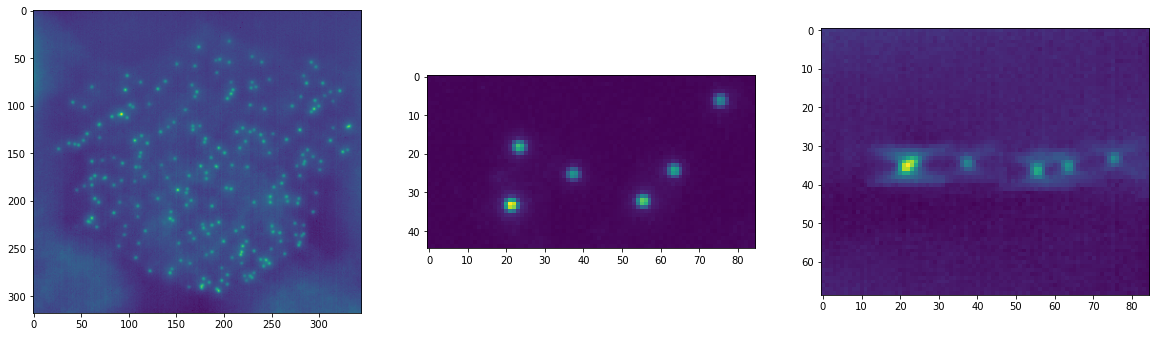

In [ ]:
win_sl = np.s_[0,:,50:95,75:160]

plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(bead_vol[0].mean(0))
plt.subplot(132)
plt.imshow(bead_vol[win_sl].max(0).values)
plt.subplot(133)
plt.imshow(bead_vol[win_sl].mean(1))

In [ ]:
#export
def get_peaks_3d(volume, threshold=500, min_distance=20):
    """Peak finding functions. Provides position estimate for bead stacks that are used as initialization for PSF fitting.
    
    Parameters
    ----------
    volume: 3D array
        Single bead recording
    threshold: float
        Initial threshold to identify pixel that are considered as possible peaks. 
    min_distance: float
        Minimal distance between two peaks in pixels
        
    Returns
    -------
    peaks: array
        Array of z,y,x peak positions
    """         
    assert threshold < volume.max() , "Threshold higher then max volume intensity, chose a lower threshold"
    
    peaks = []
    t_img = np.where(volume>threshold,volume,0)
    inds = t_img.nonzero()
    vals = t_img[inds]
    inds_zyx = [[z,y,x] for _,z,y,x in sorted(zip(vals,inds[0],inds[1],inds[2]))][::-1]    
    
    while len(inds_zyx) > 0:

        valid = True
        zyx = inds_zyx[0]
        z,y,x = zyx
        inds_zyx.remove(zyx)

        for pyx in peaks:
            if np.sqrt((z-pyx[0])**2 + (y-pyx[1])**2 + + (x-pyx[2])**2) < min_distance:
                valid = False
                break
        if valid:       
            peaks.append(zyx)
    
    peak_df = DF(data=np.array(peaks)[:,::-1], columns=['x','y','z'])
    return peak_df

In [ ]:
#export
def plot_detection(volume, coordinates):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(volume.max(0).values)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'r.')
    plt.title('Z crossection')
    plt.subplot(122)
    plt.imshow(volume.max(2).values)
    plt.plot(coordinates[:, 1], coordinates[:, 2], 'r.')
    plt.title('X crossection')
    plt.show()

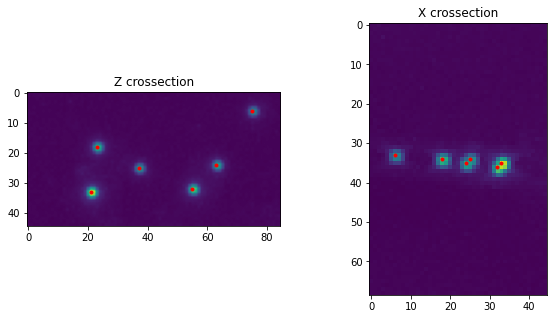

In [ ]:
coords_xyz = get_peaks_3d(bead_vol[win_sl], threshold=2000, min_distance=5)
plot_detection(bead_vol[win_sl], coords_xyz)

In [ ]:
abs_coords_xyz = np.array([c + np.array([int(win_sl[3].start or 0), int(win_sl[2].start or 0), int(win_sl[1].start or 0)]) for c in coords_xyz])

In [ ]:
# export
def extract_roi(beads: torch.Tensor, coordinates: torch.Tensor, size_xy: int=10, size_z: int=10):
    res = []
    tot_size = torch.Size([1, size_z*2+1, size_xy*2+1, size_xy*2+1])
    for i in coordinates:
        x, y, z = i
        single_bead = beads[:, z-size_z: z+size_z+1, 
                               y-size_xy: y+size_xy+1, 
                               x-size_xy: x+size_xy+1]
        
        if single_bead.size() == tot_size:
            res.append(single_bead)
        
    return torch.cat(res, 0)

In [ ]:
rois = extract_roi(bead_vol, abs_coords_xyz, size_xy=10, size_z=10)

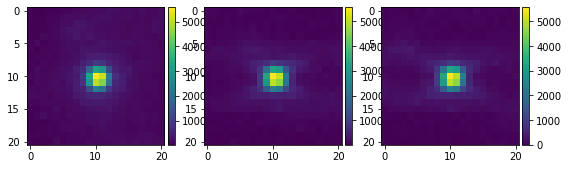

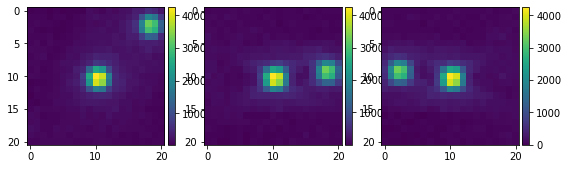

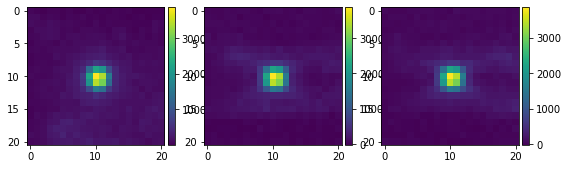

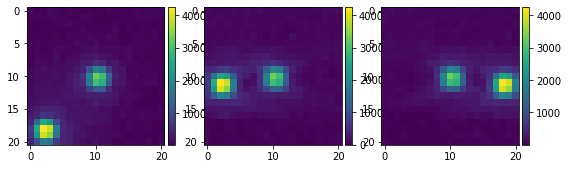

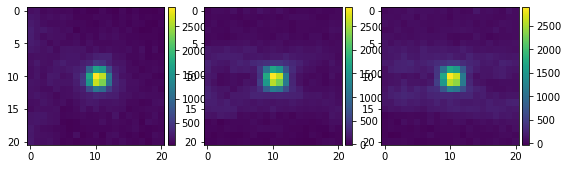

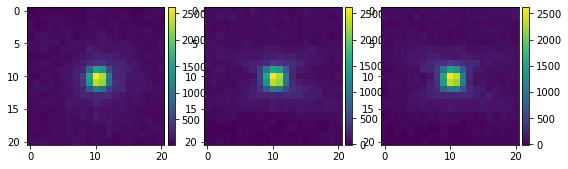

In [ ]:
for i in range(len(rois)): plot_3d_projections(rois[i], projection='max', size=3);

In [ ]:
print(rois.shape)
rois_clean = rois[[0,2,4,5]]
rois_normed = rois_clean/rois_clean.sum(-1).sum(-1).sum(-1)[:,None,None,None] * 100

extend = [0,5,5,5]
rois_extended = torch.zeros([s + 2*e for s,e in zip(rois_normed.shape,extend)])
rois_extended[:,extend[1]:-extend[1],extend[2]:-extend[2],extend[3]:-extend[3]] = rois_normed

torch.Size([6, 21, 21, 21])


In [ ]:
device='cuda'
PSF = LinearInterpolatedPSF(rois_extended.shape[-3:],1, device=device)

In [ ]:
#export
def fit_psf(PSF, roi_list, fit_lr=1e-3, fit_iteration=10000, device='cuda'):

    ground_truth = roi_list + 0
    param_list = list(PSF.parameters())
    ground_truth= ground_truth.unsqueeze(1).to(device)

    x_os_val = nn.Parameter(D.Uniform(low=0-0.5, high=0+0.5).sample((ground_truth.shape[0], 1, 1, 1)).to(device))
    y_os_val = nn.Parameter(D.Uniform(low=0-0.5, high=0+0.5).sample((ground_truth.shape[0], 1, 1, 1)).to(device))
    z_os_val = nn.Parameter(D.Uniform(low=0-0.5, high=0+0.5).sample((ground_truth.shape[0], 1, 1, 1)).to(device))
    param_list = param_list + [x_os_val, y_os_val, z_os_val]
    loss_res = []

    optim = torch.optim.AdamW(param_list, fit_lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.5)

    for i in range(fit_iteration):
        psf_volume = PSF(x_os_val, y_os_val, z_os_val)
        loss = F.mse_loss(psf_volume, ground_truth) + 1e-5*torch.norm(psf_volume.sum(), 1)
        loss_res.append(loss.detach().cpu().item())
        loss.backward()
        optim.step()
        optim.zero_grad()

        if i%1000 == 0:
            plot_3d_projections(PSF.psf_volume[0], projection='mean', size=3);
            plt.show()
        scheduler.step()
        
    return loss_res

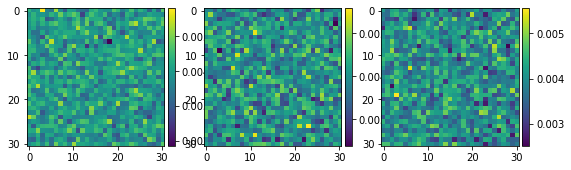

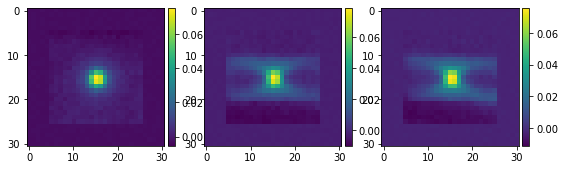

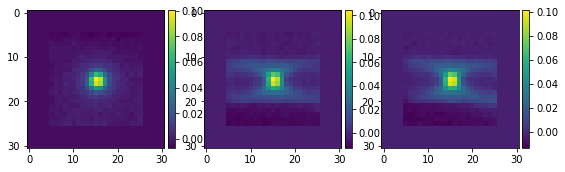

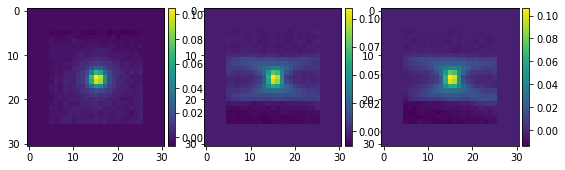

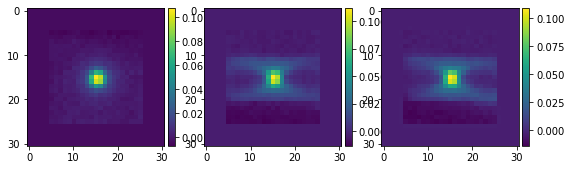

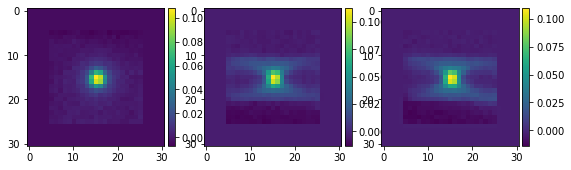

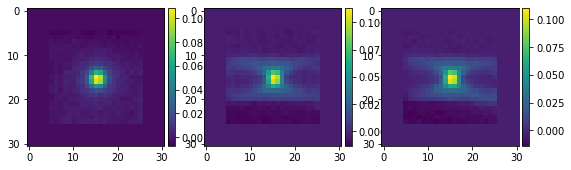

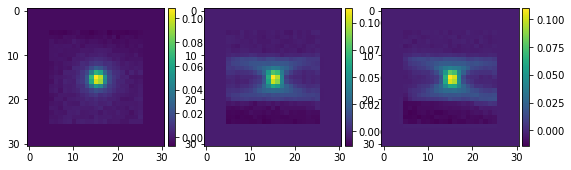

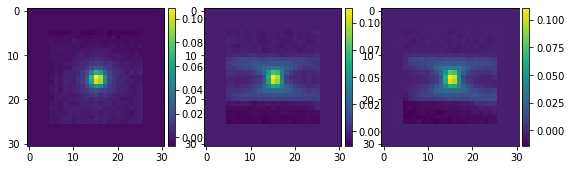

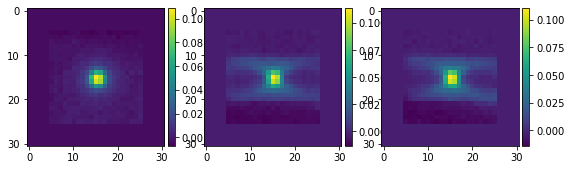

In [ ]:
loss_res = fit_psf(PSF, rois_extended)

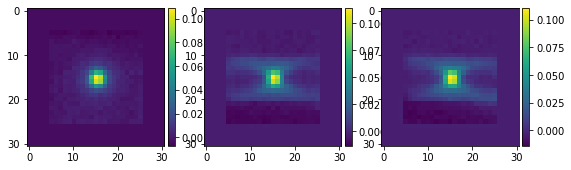

In [ ]:
plot_3d_projections(PSF.psf_volume[0], projection='mean', size=3);

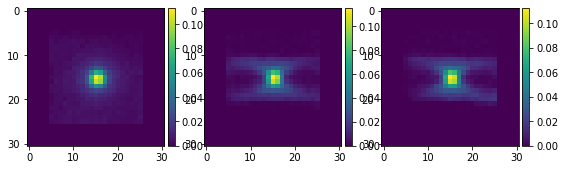

In [ ]:
plot_3d_projections(torch.clamp_min(PSF.psf_volume[0],0), projection='mean', size=3);

In [ ]:
plt.plot(loss_res)
plt.yscale('log')
plt.plot([0,10000],[np.min(loss_res),np.min(loss_res)])
plt.title(np.min(loss_res))

NameError: name 'loss_res' is not defined

In [ ]:
PSF.psf_volume.data = torch.clamp_min_(PSF.psf_volume.data, 0) 

In [ ]:
torch.save(PSF.state_dict(), '../data/simfish_psf.pkl')

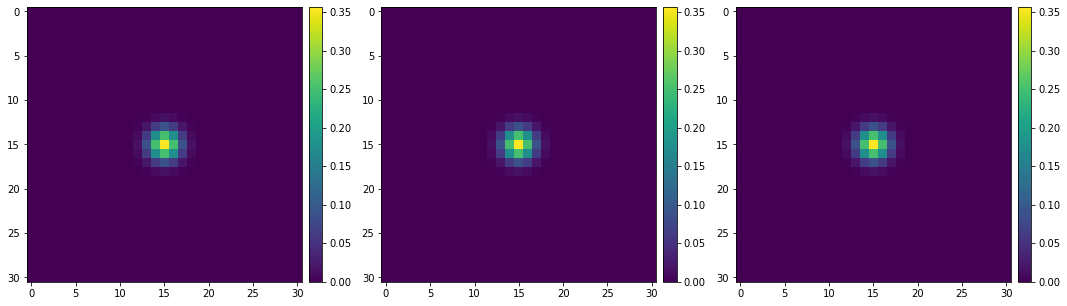

In [ ]:
from scipy import ndimage
delta = torch.zeros_like(PSF.psf_volume.detach())
delta[0,15,15,15] = 1
gauss_3d = 100*scipy.ndimage.filters.gaussian_filter(delta[0], 1.2, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
plot_3d_projections(gauss_3d)

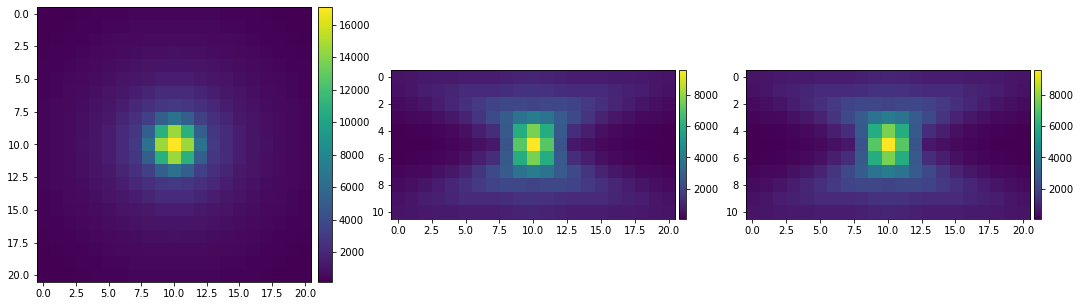

In [ ]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/PSF.tif')
plot_3d_projections(gt_psf[0,::3,::3,::3])

In [ ]:
device='cuda'
PSF = LinearInterpolatedPSF([21,21,21],1, device=device)

In [ ]:
PSF.psf_volume.data = torch.tensor(gauss_3d[None])
torch.save(PSF.state_dict(), '../data/gaussian_psf.pkl')

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
